In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql.functions import *

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/10/09 16:07:44 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.26.64.252 instead (on interface eth0)
22/10/09 16:07:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 16:07:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/09 16:07:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/09 16:07:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Income 

In [9]:
# Read in income dataset and extract useful columns

incomedf = spark.read.option("header","false").csv("../data/tables/datasource-AU_Govt_ABS-UoM_AURIN_DB_3_abs_personal_income_total_income_sa2_2011_2018.csv")
#print(incomedf.limit(5))
incomedf = incomedf.select("_c2","_c10","_c17","_c31","_c38")
print(incomedf.count())
incomedf.limit(5)

2289


_c2,_c10,_c17,_c31,_c38
sa2_code,earners_persons_2...,median_age_of_ear...,median_aud_2017_18,mean_aud_2017_18
103031075,null,null,null,null
107011133,null,null,null,null
107021135,null,null,null,null
111031230,17,46,38680,51000


Missing 21 sa2 codes <br>
47 rows have all null values so all up missing 68 sa2 regions worth of data 

In [10]:
# Have to save csv file, read it again, and rename it because the delimiters in the original csv
# dataset are commas for the header and then fullstops for the first column but commas for the rest

incomedf.write.mode(saveMode="overwrite").csv("../data/curated/income.csv")
incomedf = spark.read.csv("../data/curated/income.csv")
incomedf = incomedf.withColumnRenamed("_c0","sa2_code")
incomedf = incomedf.withColumnRenamed("_c1","num_earners")
incomedf = incomedf.withColumnRenamed("_c2","median_age")
incomedf = incomedf.withColumnRenamed("_c3","median_income")
incomedf = incomedf.withColumnRenamed("_c4","mean_income")

# Make all the numerical fields into int datatype
for field in ('num_earners',"median_age","median_income","mean_income"):
    incomedf = incomedf.withColumn(
        field,
        col(field).cast('int')
    )

print(incomedf.count())
incomedf.limit(5)

2289


sa2_code,num_earners,median_age,median_income,mean_income
213011340,11238,46,51181,61177
213021341,7942,43,57585,69301
213021344,11216,41,66161,80219
213021345,3015,41,52078,60249
213021346,9996,47,63892,90668


In [5]:
# sa2_code

# no need to perform any futher analysis as any discrepancies will be removed with an inner join on this field  

2289
2241
+----------------+----------------+----------------+
|min(num_earners)|max(num_earners)|avg(num_earners)|
+----------------+----------------+----------------+
|               3|           30022|6252.20035698349|
+----------------+----------------+----------------+



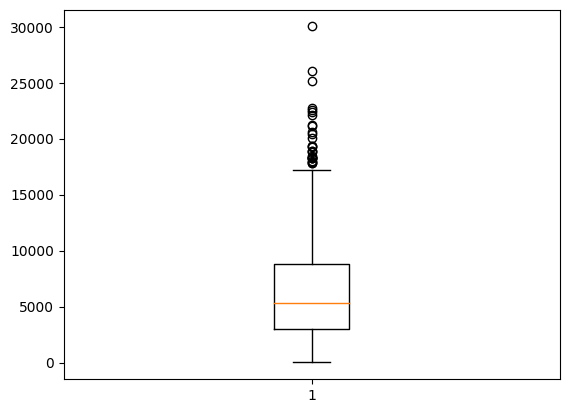

In [6]:
# num_earners analysis - make box plot to see value distribution

import matplotlib.pyplot as plt
import pandas as pd

testdf = incomedf.alias("testdf")
print(testdf.count())
testdf = testdf.dropna("all",subset="num_earners")
print(testdf.count())

print(testdf.agg(min("num_earners"), max("num_earners"), mean("num_earners")))

df = testdf.toPandas()
plt.boxplot(df["num_earners"])
plt.show()

First we check for nulls and find that 48 rows have nulls <br>
We will remove these rows as its unfair to impute a value here <br>
We could potentially use a population (sa2) dataset to make a model to predict the num_earners but there is no point because in the dataset if one row has a column with a null value then the other columns are all null too <br>
<br>

In [7]:
# Looks at the locations where the num earners is the highest

testpostcodedf = spark.read.parquet("../data/curated/testpostcodedf.parquet/")
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="num_earners")
testdf = testdf.filter(testdf["num_earners"] > 25000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
117031337,30022,30,25962,65906,SYDNEY,NSW,Sydney - Haymarke...
206041122,26083,30,28806,51528,MELBOURNE,VIC,Melbourne
503021041,25161,34,54790,79517,CITY DELIVERY CENTRE,WA,Perth City


greatest number of earners in capital cities

In [8]:
# Looks at the locations where the num earners is the lowest

testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="num_earners")
testdf = testdf.filter(testdf["num_earners"] < 10)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
117011324,6,42,89790,83273,PORT BOTANY,NSW,Port Botany Indus...
117011325,5,30,41442,50626,SYDNEY DOMESTIC A...,NSW,Sydney Airport
128021537,8,32,26370,38451,SOUTHERN SUBURBS MC,NSW,Royal National Park
205021080,3,63,31114,22659,BRUMBY,VIC,Alps - East
206041127,8,38,93272,237158,WEST MELBOURNE,VIC,West Melbourne
208031192,8,54,50000,60501,MOORABBIN AIRPORT,VIC,Moorabbin Airport
306031162,5,60,101552,95663,WOOROONOORAN,QLD,Wooroonooran
308051532,8,45,90430,98604,CALLEMONDAH,QLD,Callemondah
310021279,3,40,93966,112085,LAKE MANCHESTER,QLD,Lake Manchester -...
404031104,4,50,31934,52302,ADELAIDE AIRPORT,SA,Adelaide Airport


lowest number of earners typically in parks/airports where barely any people live <br>
locations like west mebourne caught my eye with only 8 earners which i thought was incorrect but turns out its not: <br>
Population of West Melbourne. Last official estimated population of West Melbourne (as Statistical Area Level 2) was 3 people (on 2017-06-30). <br>
(population.com.au)

2289
2241
+---------------+---------------+------------------+
|min(median_age)|max(median_age)|   avg(median_age)|
+---------------+---------------+------------------+
|             15|             71|43.077197679607316|
+---------------+---------------+------------------+



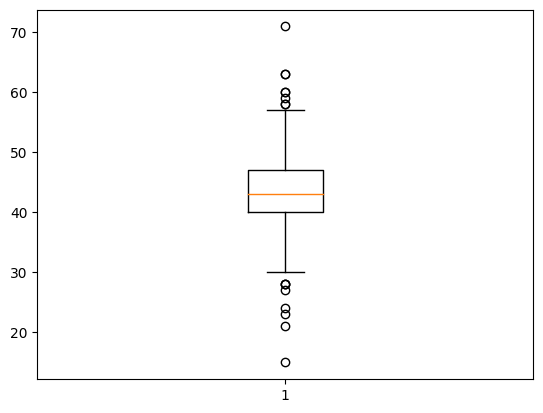

In [9]:
# median_age analysis - make box plot to see value distribution

testdf = incomedf.alias("testdf")
print(testdf.count())
testdf = testdf.dropna("all",subset="median_age")
print(testdf.count())

print(testdf.agg(min("median_age"), max("median_age"), mean("median_age")))

df = testdf.toPandas()
plt.boxplot(df["median_age"])
plt.show()

again 48 rows with nulls <br>
median ages below 20 and above 70 seem unreasonable so they will be removed considering mean retirement age is generally 65 years and the minimum age to work is around 15 years <br>

In [12]:
# Looks at the locations where the median age is the highest

testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_age")
testdf = testdf.filter(testdf["median_age"] > 70)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
504021052,5,71,1260,-1773,SAWYERS VALLEY,WA,Malmalling - Rese...


will be removed cause negative mean income

In [13]:
# Looks at the locations where the median age is the lowest

testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_age")
testdf = testdf.filter(testdf["median_age"] < 20)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016


sa2 code doesnt exist in postcodes file for 15 year median working age so will be removed

2241
2239
+---------------+---------------+-----------------+
|min(median_age)|max(median_age)|  avg(median_age)|
+---------------+---------------+-----------------+
|             21|             63|43.07726663689147|
+---------------+---------------+-----------------+



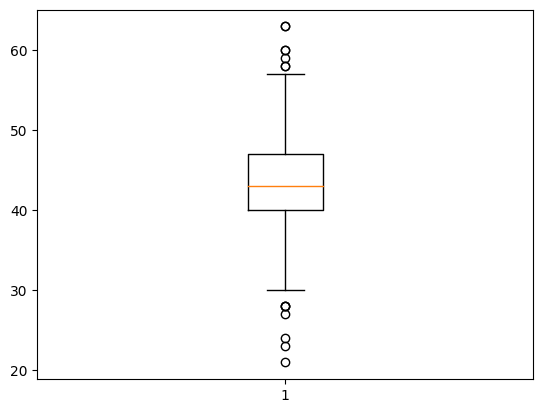

In [14]:
# Looks at the distribution if we remove the two outliers

testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_age")
print(testdf.count())
testdf = testdf.filter(testdf["median_age"] > 20)
testdf = testdf.filter(testdf["median_age"] < 70)
print(testdf.count())

print(testdf.agg(min("median_age"), max("median_age"), mean("median_age")))

df = testdf.toPandas()
plt.boxplot(df["median_age"])
plt.show()

2289
2241
+------------------+------------------+------------------+
|min(median_income)|max(median_income)|avg(median_income)|
+------------------+------------------+------------------+
|              1260|            178148| 50458.69522534583|
+------------------+------------------+------------------+



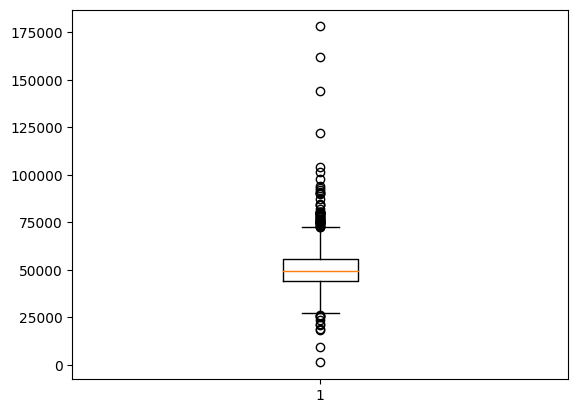

In [10]:
# median income analysis - make box plot to see value distribution

testdf = incomedf.alias("testdf")
print(testdf.count())
testdf = testdf.dropna("all",subset=["median_income"])
print(testdf.count())
print(testdf.agg(min("median_income"), max("median_income"), mean("median_income")))

df = testdf.toPandas()
plt.boxplot(df["median_income"])
plt.show()

again 48 rows with null will be removed

In [15]:
# Looks at the locations where the median income is the highest

testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_income")
testdf = testdf.filter(testdf["median_income"] > 90000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
206041127,8,38,93272,237158,WEST MELBOURNE,VIC,West Melbourne
306031162,5,60,101552,95663,WOOROONOORAN,QLD,Wooroonooran
308051532,8,45,90430,98604,CALLEMONDAH,QLD,Callemondah
310021279,3,40,93966,112085,LAKE MANCHESTER,QLD,Lake Manchester -...
406021143,2562,36,92288,95640,OLYMPIC DAM,SA,Roxby Downs
503021037,37,59,161893,356433,KINGS PARK,WA,Kings Park (WA)
506011111,4,43,143945,92309,ASHENDON,WA,Ashendon - Lesley
510021269,2834,38,90731,101819,PORT HEDLAND,WA,Port Hedland
510031271,3416,39,97795,98922,CANE,WA,Ashburton (WA)
801061068,4,53,121961,107326,CAPITAL HILL,ACT,Parkes (ACT) - South


The sa2 regions with high median income are mainly consisting of posh regions with a low population <br>

In [16]:
# Looks at the locations where the median income is the lowest

testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_income")
testdf = testdf.filter(testdf["median_income"] < 30000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
110021194,3113,54,28976,35915,STANNUM,NSW,Tenterfield
117031337,30022,30,25962,65906,SYDNEY,NSW,Sydney - Haymarke...
124011451,14,63,21247,19071,THE DEVILS WILDER...,NSW,Blue Mountains - ...
128021537,8,32,26370,38451,SOUTHERN SUBURBS MC,NSW,Royal National Park
205031088,53,57,18177,32022,ELIZABETH ISLAND,VIC,French Island
205051099,23,53,18835,27804,ARBUCKLE,VIC,Alps - West
206041122,26083,30,28806,51528,MELBOURNE,VIC,Melbourne
210011227,19,46,27711,42355,ESSENDON FIELDS,VIC,Essendon Airport
315011395,352,40,23591,38363,AURUKUN,QLD,Aurukun
315011398,585,40,25757,34917,KOWANYAMA,QLD,Kowanyama - Pormp...


The sa2 regions with low median income consist of regions that few people live in and there is little access to a good job such as mountains/parks/islands/airports <br>

2289
2241
+----------------+----------------+------------------+
|min(mean_income)|max(mean_income)|  avg(mean_income)|
+----------------+----------------+------------------+
|           -1773|          356433|62742.204373047745|
+----------------+----------------+------------------+



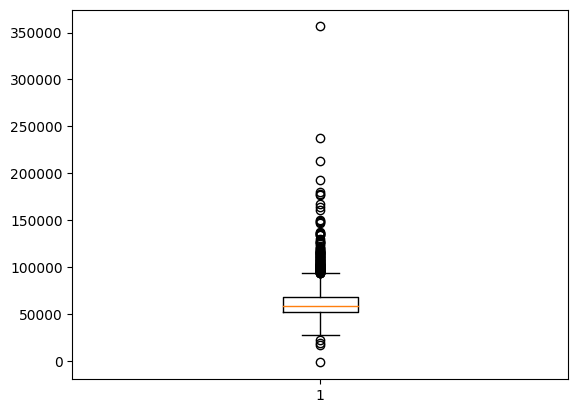

In [11]:
# mean income analysis - make box plot to see value distribution

testdf = incomedf.alias("testdf")
print(testdf.count())
testdf = testdf.dropna("all",subset=["mean_income"])
print(testdf.count())
print(testdf.agg(min("mean_income"), max("mean_income"), mean("mean_income")))

df = testdf.toPandas()
plt.boxplot(df["mean_income"])
plt.show()

again 48 rows removed due to null values <br>

In [17]:
# Looks at the locations where the mean income is the highest

testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="mean_income")
testdf = testdf.filter(testdf["mean_income"] > 150000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
118011343,18432,44,77665,176403,DOUBLE BAY,NSW,Double Bay - Bell...
118011346,8478,48,74788,192463,ROSE BAY,NSW,Rose Bay - Vauclu...
118011347,5532,45,74887,164205,WOOLLAHRA,NSW,Woollahra
121041415,20612,47,75307,166807,MOSMAN,NSW,Mosman
206041127,8,38,93272,237158,WEST MELBOURNE,VIC,West Melbourne
206061138,10250,49,72451,177645,TOORAK,VIC,Toorak
503011032,5544,49,74999,213108,COTTESLOE,WA,Cottesloe
503011034,6781,47,65623,160696,PEPPERMINT GROVE,WA,Mosman Park - Pep...
503021037,37,59,161893,356433,KINGS PARK,WA,Kings Park (WA)
801061063,1312,48,87093,150020,FORREST,ACT,Forrest


The highest mean income comes from posh regions with low populations and from wealthy regions in major cities

In [18]:
# Looks at the locations where the mean income is the lowest

testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="mean_income")
testdf = testdf.filter(testdf["mean_income"] < 25000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
124011451,14,63,21247,19071,THE DEVILS WILDER...,NSW,Blue Mountains - ...
205021080,3,63,31114,22659,BRUMBY,VIC,Alps - East
504021052,5,71,1260,-1773,SAWYERS VALLEY,WA,Malmalling - Rese...
801051049,548,23,9306,16835,ANU,ACT,Acton


The lowest mean income is similar to the lowest median income and comes from locations where not many people live and not many jobs are available such as parks/islands/mountains

It is interesting seeing that the regions with the highest median income are generally different to the regions with the highest mean income <br>
Mean being bigger then median means that there are more highly wealthy people bringing the average up <br>
this is confirmed as the bigger mean income locations mostly focus around major cities with HIGH populations where these millionaires would generally live <br>
whereas the bigger median income regions revolve around niche locations with LOW populations  

In [19]:
# Remove outliers from actual income dataset

incomedf = incomedf.dropna("any")
print(incomedf.count())
incomedf = incomedf.filter(incomedf["median_age"] > 20)
incomedf = incomedf.filter(incomedf["median_age"] < 70)
print(incomedf.count())

2241
2239


In [20]:
# Save final income dataset

incomedf.write.mode("overwrite").parquet('../data/curated/incomedf.parquet')